### 3加载已训练模型进行预测

In [2]:
from __future__ import print_function
from six.moves import cPickle as pickle

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

% matplotlib inline

In [4]:
IMAGE_SIZE = 40
NUM_DIGITS = 5
NUM_LABELS = 11 # 0-9 + 10==doesn't exist
NUM_CHANNELS = 1 # grayscale

In [5]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 24
DEPTH_2 = 48
DEPTH_3 = 64
NUM_HIDDEN = 128
SEED = 42

In [6]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(None, NUM_DIGITS))
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1), name='conv1_weights')
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]), name='conv1_biases')
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1), name='conv2_weights')
    conv2_biases = tf.Variable(tf.zeros([DEPTH_2]), name='conv2_biases')
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1), name='conv3_weights')
    conv3_biases = tf.Variable(tf.zeros([DEPTH_3]), name='conv3_biases')
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], stddev=0.1), name='fc1_weights')
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]), name='fc1_biases')
    
    #fc_numdigit_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, MAX_NUM_DIGIT], stddev=0.1))
    #fc_numdigit_biases = tf.Variable(tf.constant(1.0, shape=[MAX_NUM_DIGIT]))
    fc_digit1_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit1_weights')
    fc_digit1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit1_biases')
    fc_digit2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit2_weights')
    fc_digit2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit2_biases')
    fc_digit3_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit3_weights')
    fc_digit3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit3_biases')
    fc_digit4_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit4_weights')
    fc_digit4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit4_biases')
    fc_digit5_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit5_weights')
    fc_digit5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit5_biases')
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [-1, shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
            
        #logit_numdigit = tf.matmul(hidden, fc_numdigit_weights) + fc_numdigit_biases
        logit_digit1 = tf.matmul(hidden, fc_digit1_weights) + fc_digit1_biases
        logit_digit2 = tf.matmul(hidden, fc_digit2_weights) + fc_digit2_biases
        logit_digit3 = tf.matmul(hidden, fc_digit3_weights) + fc_digit3_biases
        logit_digit4 = tf.matmul(hidden, fc_digit4_weights) + fc_digit4_biases
        logit_digit5 = tf.matmul(hidden, fc_digit5_weights) + fc_digit5_biases
        
        return logit_digit1, logit_digit2, logit_digit3, logit_digit4, logit_digit5
    
    def predict(logits):
        return tf.transpose(tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                        tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)]))
        # return tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                       # tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)], axis=1)
        
    logits = model(tf_train_dataset)
    
    train_prediction = predict(logits)
    train_accuracy = accuracy(train_prediction, tf_train_labels)

In [7]:

def gcn(dataset):
    """Global contrast normalization"""
    mean = dataset.mean(axis=(1,2))
    std = dataset.std(axis=(1,2))
    return (dataset - mean[:, None, None]) / std[:, None, None]

### 计算测试集的分类准确率

In [58]:
def accuracy(predictions, labels):
    return np.mean(np.all(predictions == labels, axis=1))

In [8]:
pickle_file = 'svhn_multi_test.pickle'
#VALID_SIZE = 500

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    test_dataset = dataset['dataset']#[:1000]
    test_labels = dataset['labels'][:, 1:6]#[:1000]
    
print('Dataset shape: ', test_dataset.shape)
print('Labels shape: ', test_labels.shape)


Dataset shape:  (13068, 40, 40)
Labels shape:  (13068, 5)


In [46]:
images = test_dataset
test_dataset = images.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
test_dataset.shape

(13068, 40, 40, 1)

In [47]:
test_batch_size = 100

In [48]:
def next_batch(data, labels, batch_size):
    for i in range((data.shape[0] + batch_size - 1) // batch_size):
        yield data[i*batch_size:(i+1)*batch_size], labels[i*batch_size:(i+1)*batch_size]

In [62]:
prediction = np.zeros(test_labels.shape, dtype=np.int32)

In [63]:
batches = next_batch(test_dataset, test_labels, test_batch_size)

In [64]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'multi_1025.ckpt')
    for i, batch in enumerate(batches):
        prediction[i*test_batch_size:(i+1)*test_batch_size] = \
            session.run(train_prediction, feed_dict={tf_train_dataset: batch[0], tf_train_labels: batch[1]})
        

In [65]:
accuracy(prediction, test_labels)

0.83295071931435571

测试集分类准确率  
71.212128  
77.770142  
83.295071931435571

### 展示预测错误的图片

In [66]:
prediction == test_labels

array([[ True,  True,  True,  True,  True],
       [ True, False,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ..., 
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]], dtype=bool)

In [67]:
predict_correct = np.all(prediction == test_labels, axis=1)

In [68]:
predict_wrong = np.invert(predict_correct)

In [69]:
def label_to_str(label):
    s = ''
    for d in label:
        if d < 10:
            s += str(d)
        else:
            s += '*'
    return s

In [70]:
def plot_images(images, labels):
    fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(6,5))
    #fig.subplots_adjust(hspace=0.3, wspace=0.1)
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(images[i], cmap=plt.cm.gray, interpolation='none')
        ax.set_title( label_to_str(labels[i]) )

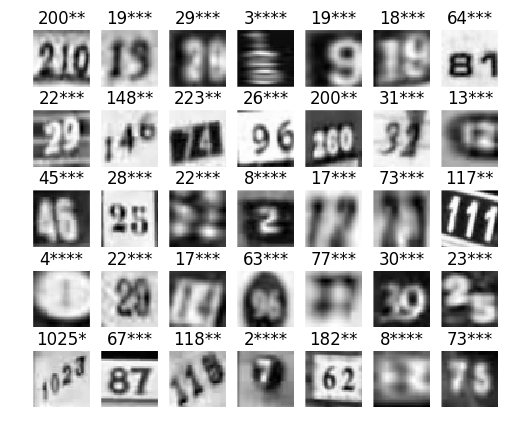

In [71]:
plot_images(test_dataset[predict_wrong].reshape((-1, IMAGE_SIZE, IMAGE_SIZE)), prediction[predict_wrong])

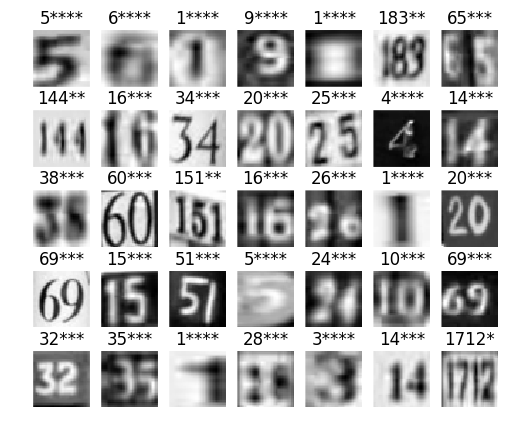

In [53]:
plot_images(test_dataset[predict_correct].reshape((-1, IMAGE_SIZE, IMAGE_SIZE)), prediction[predict_correct])

In [33]:
test_dataset[predict_wrong].reshape((-1, IMAGE_SIZE, IMAGE_SIZE)).shape

(170, 40, 40)

### 利用模型预测单张图片标签

In [ ]:
import random

In [ ]:
index = random.randint(0, test_dataset.shape[0])

In [ ]:
index

In [ ]:
image = test_dataset[index]

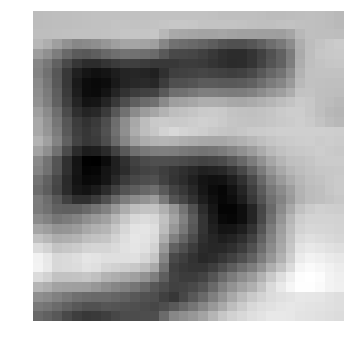

In [9]:
plt.axis('off')
plt.imshow(test_dataset[index].reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap=plt.cm.gray, interpolation='nearest')

In [12]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'multi.ckpt')
    #test_prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})
    prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})

In [13]:
prediction

77.770142

In [ ]:
test_labels[index]